In [1]:
from __future__ import print_function

from datetime import datetime
import sys

from azure.storage.file import FileService
import azure.mgmt.batchai.models as models

# utilities.py contains helper functions used by different notebooks
#sys.path.append('../../')
import utilities

cfg = utilities.Configuration('configuration.json')
client = utilities.create_batchai_client(cfg)

Keyring cache token has failed: (1783, 'CredWrite', 'The stub received bad data')


In [2]:
utilities.create_resource_group(cfg)
_ = client.workspaces.create(cfg.resource_group, cfg.workspace, cfg.location).result()

Keyring cache token has failed: (1783, 'CredWrite', 'The stub received bad data')


In [3]:

nodes_count = 1
cluster_name = 'nc6dsvm'

parameters = models.ClusterCreateParameters(
    #location=cfg.location,
    vm_size='STANDARD_NC6',
    scale_settings=models.ScaleSettings(
        manual=models.ManualScaleSettings(target_node_count=nodes_count)
    ), 
    ####### comment out this section when want to use docker image instead of dsvm###########
    virtual_machine_configuration=models.VirtualMachineConfiguration(
        image_reference=models.ImageReference(
            publisher="microsoft-ads",
            offer="linux-data-science-vm-ubuntu",
            sku="linuxdsvmubuntu",
            version="latest")),
    ###################comment out end ####################################
    user_account_settings=models.UserAccountSettings(
        admin_user_name=cfg.admin,
        admin_user_password=cfg.admin_password or None,
        admin_user_ssh_public_key=cfg.admin_ssh_key or None,
    )
)

In [4]:
_ = client.clusters.create(cfg.resource_group, cfg.workspace, cluster_name, parameters).result()

In [5]:
cluster = client.clusters.get(cfg.resource_group, cfg.workspace, cluster_name)
utilities.print_cluster_status(cluster)

Cluster state: resizing Target: 1; Allocated: 0; Idle: 0; Unusable: 0; Running: 0; Preparing: 0; Leaving: 0


In [6]:
backend = 'tensorflow'

In [13]:
if backend == 'tensorflow':
    parameters = models.JobCreateParameters(
        #location=cfg.location,
        cluster=models.ResourceId(id=cluster.id),
        node_count=1,
        job_preparation=models.JobPreparation(command_line='ls'),
        ####### only comment out the below when you use dsvm instead of docker image in parameters block above
         #container_settings=models.ContainerSettings(
         #    image_source_registry=models.ImageSourceRegistry(image='tensorflow/tensorflow:1.8.0-gpu-py3')),
        ######### commend end #########################
        mount_volumes=models.MountVolumes(
            azure_file_shares=[
            models.AzureFileShareReference(
            account_name=cfg.storage_account_name,
            credentials=models.AzureStorageCredentialsInfo(
            account_key=cfg.storage_account_key),
            azure_file_url='https://{0}.file.core.windows.net/{1}'.format(
            cfg.storage_account_name, 'bloodcell'), ## bloodcell is the name of the fileshare
            relative_mount_path='afs')
            ]
         ),
        std_out_err_path_prefix='$AZ_BATCHAI_JOB_MOUNT_ROOT/afs/ChestCTscan', ## here afs equal to bloodshare level
        tensor_flow_settings=models.TensorFlowSettings(
             python_script_file_path='$AZ_BATCHAI_JOB_MOUNT_ROOT/afs/ChestCTscan/keras_cnn_dicom.py',
             master_command_line_args='--data $AZ_BATCHAI_JOB_MOUNT_ROOT/afs/ChestCTscan/dicom/ --epoch 25 --save_model $AZ_BATCHAI_JOB_MOUNT_ROOT/afs/ChestCTscan/ ')) 

In [14]:
experiment_name = 'keras_CTscan'
experiment = client.experiments.create(cfg.resource_group, cfg.workspace, experiment_name).result()
job_name = datetime.utcnow().strftime('keras_{}_%m_%d_%Y_%H%M%S'.format(backend))
job = client.jobs.create(cfg.resource_group, cfg.workspace, experiment_name, job_name, parameters).result()
print('Created Job {0} in Experiment {1}'.format(job.name, experiment.name))

Created Job keras_tensorflow_07_06_2018_193306 in Experiment keras_ctscan


In [15]:
if backend == 'tensorflow':
    read_file = 'stdout-wk-0.txt'
elif backend == 'cntk':
    read_file = 'stdout.txt'
import utilities

utilities.wait_for_job_completion(client, cfg.resource_group, cfg.workspace, 
                                  experiment_name, job_name, cluster_name, 'stdouterr', read_file)

Cluster state: steady Target: 1; Allocated: 1; Idle: 0; Unusable: 0; Running: 1; Preparing: 0; Leaving: 0
Job state: queued ExitCode: None
Cluster state: steady Target: 1; Allocated: 1; Idle: 0; Unusable: 0; Running: 1; Preparing: 0; Leaving: 0
Job state: queued ExitCode: None
Cluster state: steady Target: 1; Allocated: 1; Idle: 0; Unusable: 0; Running: 1; Preparing: 0; Leaving: 0
Job state: queued ExitCode: None
Cluster state: steady Target: 1; Allocated: 1; Idle: 0; Unusable: 0; Running: 1; Preparing: 0; Leaving: 0
Job state: queued ExitCode: None
Cluster state: steady Target: 1; Allocated: 1; Idle: 0; Unusable: 0; Running: 1; Preparing: 0; Leaving: 0
Job state: queued ExitCode: None
Cluster state: steady Target: 1; Allocated: 1; Idle: 0; Unusable: 0; Running: 1; Preparing: 0; Leaving: 0
Job state: queued ExitCode: None
Cluster state: steady Target: 1; Allocated: 1; Idle: 0; Unusable: 0; Running: 1; Preparing: 0; Leaving: 0
Job state: queued ExitCode: None
Cluster state: steady Targe

100/100 [==============================] - 14s 144ms/step - loss: 2.1503 - acc: 0.7785 - val_loss: 0.1553 - val_acc: 0.9440
Epoch 2/25

 81/100 [=======================>......] - ETA: 1s - loss: 1.7340 - acc: 0.8562


100/100 [==============================] - 13s 125ms/step - loss: 1.7117 - acc: 0.8630 - val_loss: 0.0556 - val_acc: 0.9880
Epoch 3/25

 94/100 [===========================>..] - ETA: 0s - loss: 1.6774 - acc: 0.8814


100/100 [==============================] - 12s 124ms/step - loss: 1.6676 - acc: 0.8825 - val_loss: 0.0306 - val_acc: 0.9880
Epoch 4/25

 98/100 [============================>.] - ETA: 0s - loss: 1.6500 - acc: 0.8878


100/100 [==============================] - 12s 124ms/step - loss: 1.6419 - acc: 0.8880 - val_loss: 0.0406 - val_acc: 0.9720
Epoch 5/25

100/100 [==============================] - 12s 124ms/step - loss: 1.6329 - acc: 0.8930 - val_loss: 0.0092 - val_acc: 0.9960
Epoch 6/25

  3/100 [..............................] - ETA: 8s - loss: 1.3444 - acc: 0.9167


100/100 [==============================] - 12s 124ms/step - loss: 1.6408 - acc: 0.8890 - val_loss: 0.0313 - val_acc: 0.9880
Epoch 7/25

 11/100 [==>...........................] - ETA: 9s - loss: 1.4889 - acc: 0.8955


100/100 [==============================] - 13s 125ms/step - loss: 1.6250 - acc: 0.8945 - val_loss: 0.0049 - val_acc: 1.0000
Epoch 8/25

 17/100 [====>.........................] - ETA: 8s - loss: 1.6691 - acc: 0.8912


100/100 [==============================] - 13s 125ms/step - loss: 1.6204 - acc: 0.8965 - val_loss: 0.0116 - val_acc: 0.9960
Epoch 9/25

 22/100 [=====>........................] - ETA: 7s - loss: 1.6891 - acc: 0.8955


100/100 [==============================] - 13s 125ms/step - loss: 1.6848 - acc: 0.8900 - val_loss: 8.3349e-04 - val_acc: 1.0000
Epoch 10/25

 32/100 [========>.....................] - ETA: 6s - loss: 1.6362 - acc: 0.8891


100/100 [==============================] - 12s 124ms/step - loss: 1.6370 - acc: 0.8890 - val_loss: 0.0102 - val_acc: 1.0000
Epoch 11/25

 39/100 [==========>...................] - ETA: 6s - loss: 1.6295 - acc: 0.8936


100/100 [==============================] - 13s 125ms/step - loss: 1.6237 - acc: 0.8960 - val_loss: 0.0167 - val_acc: 0.9960
Epoch 12/25

 48/100 [=============>................] - ETA: 5s - loss: 1.6444 - acc: 0.8937


100/100 [==============================] - 13s 126ms/step - loss: 1.6221 - acc: 0.8960 - val_loss: 0.0174 - val_acc: 0.9960
Epoch 13/25

 57/100 [================>.............] - ETA: 4s - loss: 1.6023 - acc: 0.8982


100/100 [==============================] - 13s 127ms/step - loss: 1.6171 - acc: 0.8975 - val_loss: 0.0573 - val_acc: 0.9880
Epoch 14/25

 62/100 [=================>............] - ETA: 3s - loss: 1.6266 - acc: 0.8984


100/100 [==============================] - 13s 127ms/step - loss: 1.6135 - acc: 0.8990 - val_loss: 0.0066 - val_acc: 0.9920
Epoch 15/25

 75/100 [=====================>........] - ETA: 2s - loss: 1.6259 - acc: 0.8947


100/100 [==============================] - 13s 125ms/step - loss: 1.6229 - acc: 0.8960 - val_loss: 0.0018 - val_acc: 1.0000
Epoch 16/25

 89/100 [=========================>....] - ETA: 1s - loss: 1.6331 - acc: 0.8972


100/100 [==============================] - 13s 127ms/step - loss: 1.6148 - acc: 0.8985 - val_loss: 0.0022 - val_acc: 1.0000
Epoch 17/25

 98/100 [============================>.] - ETA: 0s - loss: 1.6207 - acc: 0.8995


100/100 [==============================] - 13s 126ms/step - loss: 1.6125 - acc: 0.9000 - val_loss: 0.0079 - val_acc: 0.9960
Epoch 18/25

100/100 [==============================] - 13s 126ms/step - loss: 1.6127 - acc: 0.8995 - val_loss: 0.0108 - val_acc: 0.9960
Epoch 19/25

 11/100 [==>...........................] - ETA: 9s - loss: 1.6851 - acc: 0.8955


100/100 [==============================] - 13s 126ms/step - loss: 1.6124 - acc: 0.9000 - val_loss: 0.0095 - val_acc: 0.9960
Epoch 20/25

 34/100 [=========>....................] - ETA: 6s - loss: 1.6363 - acc: 0.8985


100/100 [==============================] - 13s 126ms/step - loss: 1.6242 - acc: 0.8965 - val_loss: 0.0195 - val_acc: 0.9920
Epoch 21/25

 55/100 [===============>..............] - ETA: 4s - loss: 1.6385 - acc: 0.8918


100/100 [==============================] - 12s 124ms/step - loss: 1.6331 - acc: 0.8925 - val_loss: 9.9164e-04 - val_acc: 1.0000
Epoch 22/25

 60/100 [=================>............] - ETA: 4s - loss: 1.6124 - acc: 0.9000


100/100 [==============================] - 13s 127ms/step - loss: 1.6131 - acc: 0.8995 - val_loss: 0.0013 - val_acc: 1.0000
Epoch 23/25

 75/100 [=====================>........] - ETA: 2s - loss: 1.6126 - acc: 0.8993


100/100 [==============================] - 13s 126ms/step - loss: 1.6125 - acc: 0.8995 - val_loss: 0.0080 - val_acc: 0.9960
Epoch 24/25

 89/100 [=========================>....] - ETA: 1s - loss: 1.6028 - acc: 0.9006


100/100 [==============================] - 12s 124ms/step - loss: 1.6119 - acc: 0.9000 - val_loss: 6.5168e-05 - val_acc: 1.0000
Epoch 25/25

 94/100 [===========================>..] - ETA: 0s - loss: 1.6320 - acc: 0.8973


100/100 [==============================] - 13s 127ms/step - loss: 1.6179 - acc: 0.8980 - val_loss: 0.0098 - val_acc: 0.9920
Job state: succeeded ExitCode: 0


In [16]:
from azure.storage.file import FileService
file_service = FileService(cfg.storage_account_name, cfg.storage_account_key)
generator = file_service.list_directories_and_files('bloodcell/ChestCTscan/')
for file_or_dir in generator:
    print(file_or_dir.name, file_or_dir.metadata)

ChestCTscan_epoch25.h5 None
keras_cnn_2.py None
keras_cnn_dicom.py None
keras_cnn_pydicom.py None
overview.csv None
60be94cf-bd71-4d05-b7ce-d05fb5968d66 None
dicom None
tiff_img None


In [ ]:
#file_service.get_file_to_path('bloodcell/ChestCTscan/',None ,'ChestCTscan_epoch200.h5','model200epoch.h5')

In [17]:
import os
os.listdir('.')
from keras.models import load_model

# Returns a compiled model identical to the previous one
model = load_model('ChestCTscan_epoch25.h5')

Using TensorFlow backend.


In [18]:
#### read in dicom images
import pydicom
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot, cm
import numpy as np
import pydicom
import scipy.ndimage
#resize the image to desired resolution
xsize = 256; ysize = 256

data = np.zeros((xsize, ysize, 100))
for i, s in enumerate(os.listdir('./dicom_dir/')):

    img = np.array(pydicom.read_file('./dicom_dir' + '/' + s).pixel_array)
    xscale = xsize/img.shape[0]
    yscale = ysize/img.shape[1]
    data[:,:,i] = scipy.ndimage.interpolation.zoom(img, [xscale, yscale])
X=np.moveaxis(data, -1, 0)

In [19]:
df=pd.read_csv('overview.csv',encoding='utf-8',sep=',')
del df['Unnamed: 0']
y=df.iloc[:,1].values
y= np.array([1 if yi else 0 for yi in y])
y[:10]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

(256, 256)
(1, 256, 256, 1)
predicted  contrast


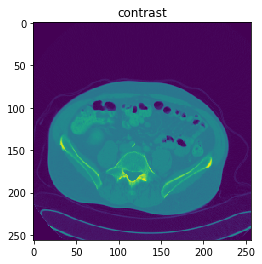

In [20]:
import random
import matplotlib.pyplot as plt
contrastYN=dict([(1,'contrast'),(0,'no_contrast')])
rn=random.randint(0,len(X))

answer=contrastYN[y[rn]]
rn_img=X[rn]
print(rn_img.shape)
plt.imshow(X[rn,:,:])
plt.title(answer)
rn_img=np.expand_dims(rn_img, axis=0)
rn_img=np.expand_dims(rn_img, axis=3)
print(rn_img.shape)
pred=model.predict(rn_img)
print("predicted ",contrastYN[int(pred[0][0])])

In [21]:
_ = client.jobs.delete(cfg.resource_group, cfg.workspace, experiment_name, job_name)

In [22]:
_ = client.clusters.delete(cfg.resource_group, cfg.workspace, cluster_name)